# Bayes factor analysis

In the current notebook, we take the results of the PyMC3 pipeline and compare the Bayes factors between models. We inspect a series of human liver and mouse neuron cell types, and consider Markovian and non-Markovian model fits between single-cell and single-nucleus data, using the Singh--Bokes bursty Markovian model as a baseline.

## Metadata and prerequisites

Define prerequisite packages and functions.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis,cme_toolbox

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm
import pymc3 as pm
import theano.tensor as tt

This cell creates an interface to PyMC3.

In [3]:

# from monod import cme_toolbox

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood,n_cells):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        self.n_cells = n_cells
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data,self.n_cells) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood



This cell defines the biophysical models.

In [4]:
def ll_bursty(p, mx, data,n_cells):
    return fitmodel_burst.eval_model_logL(p,mx,None,data,n_cells)
def ll_extrinsic(p, mx, data,n_cells):
    return fitmodel_ext.eval_model_logL(p,mx,None,data,n_cells)
def ll_delay(p, mx, data,n_cells):
    return fitmodel_delay.eval_model_logL(p,mx,None,data,n_cells)
def ll_delayedsplicing(p, mx, data,n_cells):
    return fitmodel_delsplic.eval_model_logL(p,mx,None,data,n_cells)
fitmodel_burst = monod.cme_toolbox.CMEModel('Bursty','None')
fitmodel_ext = monod.cme_toolbox.CMEModel('Extrinsic','None')
fitmodel_delay = monod.cme_toolbox.CMEModel('Delay','None')
fitmodel_delsplic = monod.cme_toolbox.CMEModel('DelayedSplicing','None')

fitmodels = [fitmodel_burst,fitmodel_ext,fitmodel_delay,fitmodel_delsplic]

These parameter names are incorrect (alpha should be b for the last two lists), but this is immaterial, because these are just attribute names.

In [5]:
par_names_pymc3 = [['b','beta','gamma'],['alpha','beta','gamma'], ['alpha','beta','tauinv'],['alpha','tauinv','gamma']]



## Define the dataset metadata and disk locations.

In [6]:
dir_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/raw/'
out_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/'
dataset_meta = ['B08','A02']
cluster_names = ['Glutamatergic','GABAergic']
allen_dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]
dataset_meta = ['sc','sn']

cluster_names = ['CentralHep','PortalHep','InterHep']
liver_dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]
dataset_names = allen_dataset_names + liver_dataset_names

Do not run this cell if you already have the post-raw pickle files, as it takes quite a lot of time.

In [810]:
models = ['bursty','extrinsic','delay','delayedsplicing']
for dataset in tqdm(dataset_names):
    for model_ind,model in enumerate(models):
        raw_str = dir_string+dataset+'_'+model+'.pickle'
        out_str = out_string+dataset+'_'+model+'.pickle'
        
        with open(raw_str, 'rb') as f:
            trace_pickle = pickle.load(f)
            
        n_genes = len(trace_pickle)
        n_steps = 1000
        trace_variable_values = np.zeros((n_genes,3,n_steps))
        lml_values = np.zeros(n_genes)
        
        for i in range(n_genes):
            lml_values[i] = trace_pickle[i].report.log_marginal_likelihood
            for var_ in range(3):
                trace_variable_values[i,var_,:] = getattr(trace_pickle[i],par_names_pymc3[model_ind][var_])
        with open(out_str, 'wb') as f:
            pickle.dump((trace_variable_values,lml_values),f)

## Reload the search results (now condensed)

In [11]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm
import scipy
from scipy import stats

In [12]:
dir_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/raw/'
out_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/'
dataset_meta = ['B08','A02']
cluster_names_allen = ['Glutamatergic','GABAergic']
allen_dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names_allen]
dataset_meta = ['sc','sn']

cluster_names_liver = ['CentralHep','PortalHep','InterHep']
liver_dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names_liver]
dataset_names = allen_dataset_names + liver_dataset_names

Load in results.

In [13]:
models = ['bursty','extrinsic','delay','delayedsplicing']

out_str = out_string+allen_dataset_names[0]+'_'+models[0]+'.pickle'
with open(out_str, 'rb') as f:
    trace_variable_values,lml_values=pickle.load(f)
n_genes_allen = len(lml_values)

out_str = out_string+liver_dataset_names[0]+'_'+models[0]+'.pickle'
with open(out_str, 'rb') as f:
    trace_variable_values,lml_values=pickle.load(f)
n_genes_liver = len(lml_values)

BFs_allen = np.zeros((len(allen_dataset_names),3,n_genes_allen))
BFs_liver = np.zeros((len(liver_dataset_names),3,n_genes_liver))

for dataset_ind,dataset in enumerate(allen_dataset_names):
    for model_ind,model in enumerate(models):
        out_str = out_string+dataset+'_'+model+'.pickle'
        with open(out_str, 'rb') as f:
            trace_variable_values,lml_values=pickle.load(f)
        if model_ind==0:
            LML_bursty = lml_values
        else:
            BFs_allen[dataset_ind,model_ind-1,:] = (lml_values-LML_bursty)/np.log(10)
        
                
for dataset_ind,dataset in enumerate(liver_dataset_names):
    for model_ind,model in enumerate(models):
        out_str = out_string+dataset+'_'+model+'.pickle'
        with open(out_str, 'rb') as f:
            trace_variable_values,lml_values=pickle.load(f)
        if model_ind==0:
            LML_bursty = lml_values
        else:
            BFs_liver[dataset_ind,model_ind-1,:] = (lml_values-LML_bursty)/np.log(10)


Plot BF distributions for Allen data...

extrinsic
allen_B08_Glutamatergic
allen_A02_Glutamatergic
allen_B08_GABAergic
allen_A02_GABAergic
delay
allen_B08_Glutamatergic
allen_A02_Glutamatergic
allen_B08_GABAergic
allen_A02_GABAergic
delayedsplicing
allen_B08_Glutamatergic
allen_A02_Glutamatergic
allen_B08_GABAergic
allen_A02_GABAergic


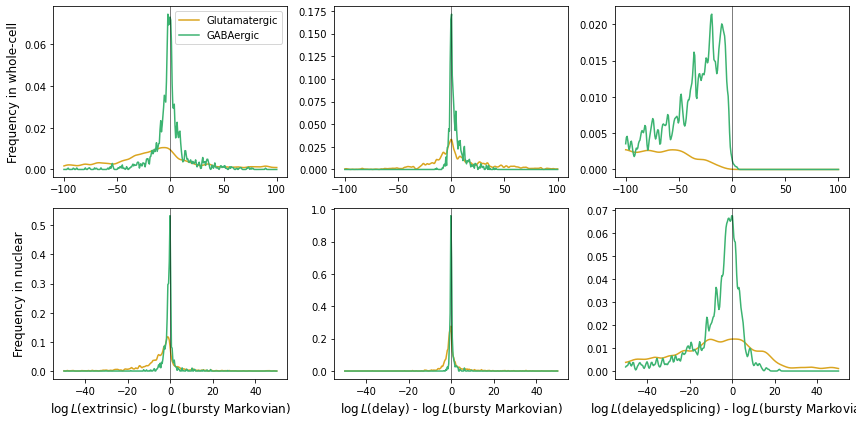

In [18]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')
# cluster
model_names = models[1:]
kdes_allen = np.empty((3,2,2),dtype=object) #model, cell type, tech

for model_index in range(3):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,2],[1,3]]):
        print(allen_dataset_names[di[0]])
#         print(cluster_names_allen[cluster_index])
        
        lim = 100
        linsp_n = 300
        sc_bf = BFs_allen[di[0],model_index]
#         ax1[0,model_index].hist(sc_bf,50,alpha=0.2,color=colors[cluster_index])
        sc_kde=scipy.stats.gaussian_kde(sc_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names_allen[cluster_index]}',color=colors[cluster_index])
        print(allen_dataset_names[di[1]])
        lim = 50
        sn_bf = BFs_allen[di[1],model_index]
        sn_kde=scipy.stats.gaussian_kde(sn_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
#         ax1[1,model_index].hist(sn_bf,50,alpha=0.2,color=colors[cluster_index])
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names_allen[cluster_index]}',color=colors[cluster_index])
        
        kdes_allen[model_index,cluster_index,0] = sc_kde
        kdes_allen[model_index,cluster_index,1] = sn_kde
        
        

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\log L$({model_names[model_index]}) - $\log L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()


...and for the liver data.

extrinsic
CentralHep
PortalHep
InterHep
delay
CentralHep
PortalHep
InterHep
delayedsplicing
CentralHep
PortalHep
InterHep


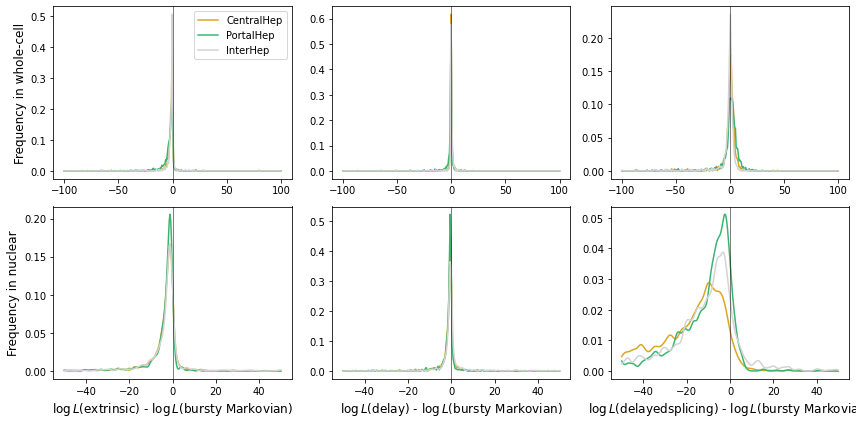

In [19]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')
# cluster
model_names = models[1:]
kdes_liver = np.empty((3,3,2),dtype=object) #model, cell type, tech

for model_index in range(3):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,3],[1,4],[2,5]]):
        print(cluster_names_liver[cluster_index])
        
        lim = 100
        linsp_n = 300
        sc_bf = BFs_liver[di[0],model_index]
        sc_kde=scipy.stats.gaussian_kde(sc_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names_liver[cluster_index]}',color=colors[cluster_index])
        
        lim = 50
        sn_bf = BFs_liver[di[1],model_index]
        sn_kde=scipy.stats.gaussian_kde(sn_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names_liver[cluster_index]}',color=colors[cluster_index])
        
        kdes_liver[model_index,cluster_index,0] = sc_kde
        kdes_liver[model_index,cluster_index,1] = sn_kde
        
        

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\log L$({model_names[model_index]}) - $\log L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()


Note that, of course, these "log L" values refer to log10 marginal likelihood differences.

## Visualize all BF distributions

Plot KDEs of likelihood ratios for both datasets.

In [20]:
kdes_allen.shape

(3, 2, 2)

In [21]:
kdes_liver.shape

(3, 3, 2)

In [22]:
kdes = np.concatenate((kdes_allen,kdes_liver),axis=1)

In [23]:
cluster_names = ['Glutamatergic','GABAergic','CentralHep','PortalHep','InterHep']

In [24]:
model_names_axes = ('extrinsic','delayed efflux','delayed splicing')

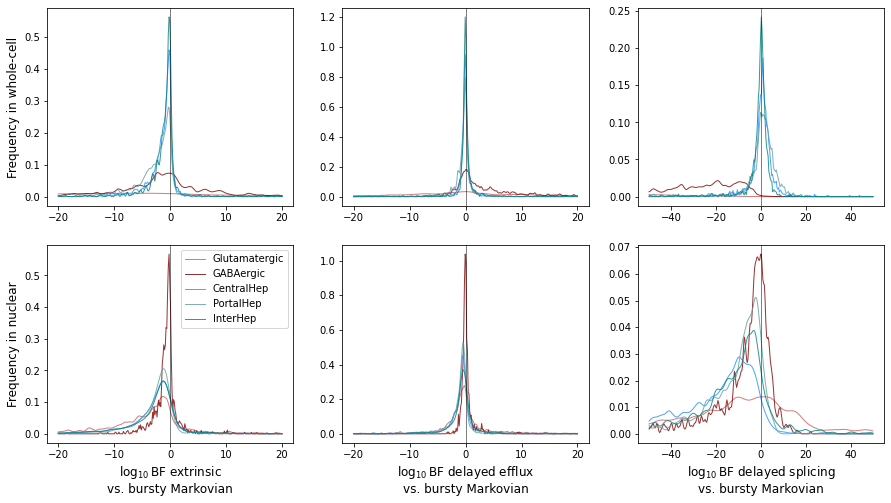

In [25]:
fig1,ax1=plt.subplots(2,3,figsize=(15,8))
colors = ('indianred','maroon','dodgerblue','cadetblue','teal')

for tech in range(2):
    for model_index in range(3):
        for cluster_index in range(5):
            kde = kdes[model_index,cluster_index,tech]
#             lim=50
            lim = 50 if model_index==2 else 20
            linsp_n = 300
            x = np.linspace(-lim,lim,linsp_n)
            ax1[tech,model_index].plot(x,kde(x),\
                                 label=f'{cluster_names[cluster_index]}',\
                                 color=colors[cluster_index],alpha=0.8,linewidth=1)

        yl = ax1[tech,model_index].get_ylim()
        ax1[tech,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[tech,model_index].set_ylim(yl)

for model_index in range(3):
    ax1[1,model_index].set_xlabel(r'$\log_{10}$BF '+f'{model_names_axes[model_index]}\nvs. bursty Markovian',fontsize=fs)
ax1[1,0].legend()
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
plt.savefig('./fig/fig2b.png',dpi=450)



## Visualize spliced and unspliced abundance

In [26]:
allen_dataset_names

['allen_B08_Glutamatergic',
 'allen_B08_GABAergic',
 'allen_A02_Glutamatergic',
 'allen_A02_GABAergic']

In [27]:
monod_dir_allen = '/home/ggorin/projects/GYP_2022/fits/gg_230620_026_allen_1'
monod_dir_liver = '/home/ggorin/projects/GYP_2022/fits/gg_230621_026_liver_andrews_1'
sd_arr = [monod.analysis.load_search_data(monod_dir_allen+'/'+x+'/raw.sd') for x in allen_dataset_names] \
        +[monod.analysis.load_search_data(monod_dir_liver+'/'+x+'/raw.sd') for x in liver_dataset_names]


In [28]:
dataset_names

['allen_B08_Glutamatergic',
 'allen_B08_GABAergic',
 'allen_A02_Glutamatergic',
 'allen_A02_GABAergic',
 'liver_c72_sc_CentralHep',
 'liver_c72_sc_PortalHep',
 'liver_c72_sc_InterHep',
 'liver_c72_sn_CentralHep',
 'liver_c72_sn_PortalHep',
 'liver_c72_sn_InterHep']

In [29]:
tot_wc = np.asarray([[sd_arr[j].layers[0].sum(),sd_arr[j].layers[1].sum()] for j in [0,1,4,5,6]],dtype=float)
tot_nuc = np.asarray([[sd_arr[j].layers[0].sum(),sd_arr[j].layers[1].sum()] for j in [2,3,7,8,9]],dtype=float)
tot_wc /= tot_wc.sum(1)[:,None]
tot_nuc /= tot_nuc.sum(1)[:,None]

Plot the unspliced count fractions.

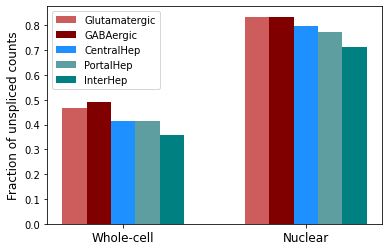

In [30]:
plt.bar(np.arange(5)*0.2-0.4,tot_wc[:,0],0.2,color=colors)
plt.bar(np.arange(5)*0.2+1.1,tot_nuc[:,0],0.2,color=colors)
plt.xticks([0,1.5],('Whole-cell','Nuclear'),fontsize=12)
plt.ylabel('Fraction of unspliced counts',fontsize=12)
from matplotlib.patches import Rectangle

handles = [Rectangle((0,0),1,1,color=c,ec="None") for c in colors]
plt.legend(handles, cluster_names)
plt.savefig('./fig/fig1c.png',dpi=450)


## Visualize single-dataset results

In [31]:
dataset_index = 3

In [32]:
sd=sd_arr[dataset_index]

In [33]:
dataset_names[dataset_index]

'allen_A02_GABAergic'

In [34]:
allen_dataset_names[dataset_index]

'allen_A02_GABAergic'

In [35]:
sd.layers.shape

(2, 1319, 1253)

Extract MCMC traces and the log-marginal likelihood values for all four models (for one dataset).

In [36]:
traces = []
lmls = []
for model_ind,model in enumerate(models):
    out_str = out_string+allen_dataset_names[dataset_index]+'_'+model+'.pickle'
    with open(out_str, 'rb') as f:
        trace_variable_values,lml_values=pickle.load(f)
    traces.append(trace_variable_values)
    lmls.append(lml_values)

In [37]:
lmls = np.asarray(lmls)

Convert log-marginal likelihoods to model probabilities (assuming uniform prior).

In [42]:
wts = np.exp(lmls-scipy.special.logsumexp(lmls,0))
print(wts.shape)

(4, 1319)


Obtain genes most consistent with each model.

In [45]:
inds = [np.argmax(x) for x in wts]
print(inds)

[216, 795, 563, 106]


Compute mean of the posterior for each MCMC trace.

In [48]:
print(traces[0].shape)
mean_pars = np.asarray([x.mean(2) for x in traces])
print(mean_pars.shape)

(1319, 3, 1000)
(4, 1319, 3)


In [49]:
modelcols = ('firebrick','deepskyblue','olive','orange')

In [50]:
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]

Plot posteriors. Are we actually justified in taking the mean? 

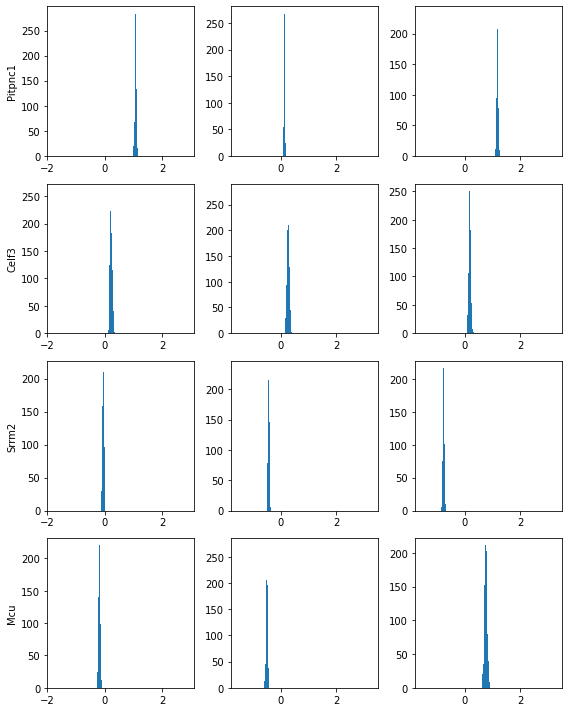

In [52]:
fig1,ax1=plt.subplots(4,3,figsize=(8,10))
for k in range(4):
    ax1[k,0].set_ylabel(sd.gene_names[inds[k]])
    for j in range(3):
        ax1[k,j].hist(traces[k][inds[k],j,:])
        ax1[k,j].set_xlim(phys_lb[j],phys_ub[j])
fig1.tight_layout()

In [53]:
model_names_axes2 = ('Markov','extrinsic','delayed efflux','delayed splicing')

Plot marginals for the four genes identified.

0.3541541830136989
0.5190928346090014
0.27512591743314235
0.07359218626809862


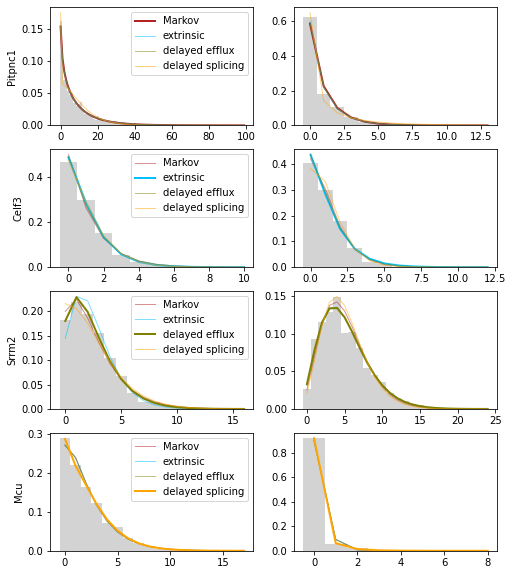

In [55]:
fig1,ax1=plt.subplots(4,2,figsize=(8,10))
for k in range(4):
    ax1[k,0].set_ylabel(sd.gene_names[inds[k]])
    data = sd.layers[:,inds[k],:]
    U = data[0]
    S = data[1]
    
    bins = np.arange(U.max()+2)-0.5
    ax1[k,0].hist(U,bins,color='lightgray',density=True)
    
    bins = np.arange(S.max()+2)-0.5
    ax1[k,1].hist(S,bins,color='lightgray',density=True)
    
    for model_ind in range(4):
        lm = [U.max()+5,1]
        lw_ = 2 if model_ind==k else 1
        alpha=1 if model_ind==k else 0.5
        
        p = mean_pars[model_ind,inds[k],:]
        Pss = fitmodels[model_ind].eval_model_pss(p,lm)
        ax1[k,0].plot(Pss,color=modelcols[model_ind],linewidth=lw_,alpha=alpha,label=model_names_axes2[model_ind])

        lm = [1,S.max()+5]
        Pss = fitmodels[model_ind].eval_model_pss(p,lm)
        ax1[k,1].plot(Pss,color=modelcols[model_ind],linewidth=lw_,alpha=alpha,label=model_names_axes2[model_ind])
    print(np.corrcoef(U,S)[0,1])
    ax1[k,0].legend()

Now, we would like to summarize more that just these four genes. It turns out that the assignment is closely related to two observed statistics: the "burst size"* -- here, the logarithm of the Fano factor, less one -- and the correlation between nascent and mature molecule counts.

\* I use this term as a shorthand for the sample Fano factor, less one. This quantity is usually very close to the burst size inferred for the bursty Markovian model (because it is the method of moments estimate for this parameter). 

In [63]:
logFanos = np.log10(sd.layers[0,:,:].var(1)/sd.layers[0,:,:].mean(1)-1)

In [64]:
corrs_ = np.asarray([scipy.stats.pearsonr(sd.layers[0,i,:],sd.layers[1,i,:])[0] for i in range(n_genes_allen)])

It is somewhat challenging to get confidence intervals for the "burst size." But for correlations, it simply requires a Fisher transformation. Let's evaluate the 95% CIs.

In [65]:
n_cells = sd.layers.shape[2]
rho_ = np.arctanh(corrs_)
corrs_lower = np.zeros_like(corrs_)
corrs_upper = np.zeros_like(corrs_)
cl_lower = np.tanh(rho_ - 1.96/np.sqrt(n_cells-3))
cl_upper = np.tanh(rho_ + 1.96/np.sqrt(n_cells-3))
yerr = np.asarray([corrs_-cl_lower,cl_upper-corrs_])

In [66]:
#https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
#machinery to put in insets
def add_subplot_axes(ax,rect,facecolor='None'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
#     subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
#     x_labelsize *= rect[2]**0.5
#     y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
#     subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


Given a particular "burst size", we can set an upper bound on the correlation between nascent and mature RNA for the bursty models. For the Markov model, this bound is analytically tractable. For the delayed-export model, it requires numerical root-finding. For the delayed-splicing model, it is zero.

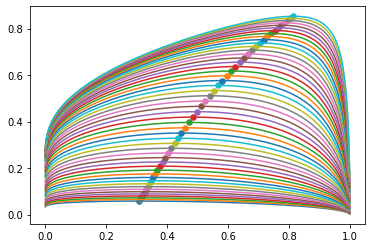

In [67]:
b_ = np.linspace(-1,1.5,50)
upperlim_corr = np.zeros_like(b_)
for bind,b___ in enumerate(b_):
    b = 10**b___
    objfun = lambda q: -b*(1-q)/np.sqrt(-np.log(q) * (1+b)*(1-2*b/np.log(q)*(q-1-np.log(q))))
    q_ = np.linspace(0.001,1-0.001,1000)
    corr__ = -np.asarray([objfun(q) for q in q_])
    plt.plot(q_,corr__)
    amax = np.argmax(corr__)
    plt.scatter(q_[amax],corr__[amax],30)
    res_ = scipy.optimize.minimize_scalar(objfun,method='bounded',bounds=[1e-10,1-1e-10]).x
    upperlim_corr[bind] = -objfun(res_)


In [68]:
import matplotlib.patheffects as PathEffects


In [71]:
model_names_axes3 = ('Bursty Markovian','Extrinsic','Delayed efflux','Delayed splicing')

In [ ]:
fig1,ax1=plt.subplots(4,3,figsize=(12,10))
x = logFanos
y=corrs_
# y = means_
xscales = [0.07]*4
# ylims = 
yscales=[0.05]*4
yl_corr = [-.3,0.9]
xl_corr = [-1.7,1.7]
for i in range(4):
#     axl = np.unravel_index(i,[2,2])
    ax1[i,0].errorbar(x,y,yerr=yerr,markersize=2,color='lightgray',alpha=0.3,linestyle='None')
    bfs_targ = wts[i]
    cf = bfs_targ>0.5
#     ax1[axl].scatter(x[cf],y[cf],3,'k',alpha=0.9)
#     ax1[axl].scatter(x[cf],y[cf],3,'k',alpha=0.9)
    ax1[i,0].errorbar(x[cf],y[cf],yerr=yerr[:,cf],markersize=3,color='k',alpha=0.4,linestyle='None')
    ax1[i,0].errorbar(x[inds[i]],y[inds[i]],yerr=yerr[:,inds[i]][:,None],
                      markersize=5,color='magenta',alpha=1,linestyle='None',
                     linewidth=4)
    offs=0.05
    txt=ax1[i,0].text(x[inds[i]]+offs,y[inds[i]]+offs,sd.gene_names[inds[i]],color='magenta',fontsize=12)
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w',alpha=0.9)])

    xl_range = np.linspace(xl_corr[0],xl_corr[1])
    kde_x = scipy.stats.gaussian_kde(x[~cf],bw_method=0.1)
    ax1[i,0].plot(xl_range,xscales[i]*kde_x(xl_range)+yl_corr[0],color='lightgray')
    kde_x = scipy.stats.gaussian_kde(x[cf],bw_method=0.1)
    ax1[i,0].plot(xl_range,xscales[i]*kde_x(xl_range)+yl_corr[0],color='k')
    ax1[i,0].set_ylim(yl_corr)
    
    yl_range = np.linspace(yl_corr[0],yl_corr[1])
    kde_y = scipy.stats.gaussian_kde(y[~cf],bw_method=0.1)
    ax1[i,0].plot(yscales[i]*kde_y(yl_range)+xl_corr[0],yl_range,color='lightgray')
    kde_y = scipy.stats.gaussian_kde(y[cf],bw_method=0.1)
    ax1[i,0].plot(yscales[i]*kde_y(yl_range)+xl_corr[0],yl_range,color='k')
    ax1[i,0].set_ylim(yl_corr)
    ax1[i,0].set_xlim(xl_corr)

    if i==0 or i==1 or i==2:
        b_ = np.linspace(xl_corr[0],xl_corr[1])
        b = 10**b_
        F = (np.sqrt(b+1)-1)/b
        rho = np.sqrt(b**2*F*(1-F)/(1+b)/(1+b*F))
        ax1[i,0].plot(b_,rho,color=modelcols[0])
    if i==2:
        ax1[i,0].plot(b_,upperlim_corr,color=modelcols[1])
    if i==3:
        b_ = np.linspace(-1,1.5)
        ax1[i,0].plot(b_,np.zeros_like(b_),color=modelcols[3])
    ax1[i,0].set_ylabel('Correlation')
    ax1[i,0].set_xlabel(r'$log_{10}$ nascent Fano - 1')
    ax1[i,0].set_title(model_names_axes3[i] + ' genes')
    
    
    
    data = sd.layers[:,inds[i],:]
    U = data[0]
    S = data[1]
    
    
    bins = np.arange(U.max()+2)-0.5
    ax1[i,1].hist(U,bins,color='lightgray',density=True)
    
    bins = np.arange(S.max()+2)-0.5
    ax1[i,2].hist(S,bins,color='lightgray',density=True)
    
    
    for model_ind in range(4):
        lm = [U.max()+5,1]
        lw_ = 2 if model_ind==i else 1
        alpha=1 if model_ind==i else 0.5
        zord=100 if model_ind==i else 1
        p = mean_pars[model_ind,inds[i],:]
        Pss = fitmodels[model_ind].eval_model_pss(p,lm)
        ax1[i,1].plot(Pss,color=modelcols[model_ind],linewidth=lw_,alpha=alpha,label=model_names_axes3[model_ind],
                     zorder=zord)

        lm = [1,S.max()+5]
        Pss = fitmodels[model_ind].eval_model_pss(p,lm)
        ax1[i,2].plot(Pss,color=modelcols[model_ind],linewidth=lw_,alpha=alpha,label=model_names_axes3[model_ind],
                     zorder=zord)
        
        ax1[i,1].set_yticks([])
        ax1[i,1].set_title('Nascent distribution')
        ax1[i,2].set_yticks([])
        ax1[i,2].set_title('Mature distribution')
#     print(np.corrcoef(U,S)[0,1])
    ax1[i,2].legend()
    
    
    
correct_param_names = [[r'$\log_{10}b$',r'$\log_{10}\beta$',r'$\log_{10}\gamma$'],\
                       [r'$\log_{10}\nu$',r'$\log_{10}\beta$',r'$\log_{10}\gamma$'],\
                       [r'$\log_{10}b$',r'$\log_{10}\beta$',r'$\log_{10}\tau^{-1}$'],\
                       [r'$\log_{10}b$',r'$\log_{10}\tau^{-1}$',r'$\log_{10}\gamma$'],]
fig1.tight_layout()
for i in range(4):
    dx = 0.15
    spac = 0.08
    for k in range(3):
        subax = add_subplot_axes(ax1[i,1],rect= [0.33+dx*k + spac*k,0.6,dx,0.3])
        bins = np.linspace(phys_lb[k],phys_ub[k],20)
        subax.hist(traces[i][inds[i],k,:],bins=bins,density=True,color='darkgray')
        subax.set_xlim(phys_lb[k],phys_ub[k])
        
        subax.spines['top'].set_visible(False)
        subax.spines['right'].set_visible(False)
        subax.spines['left'].set_visible(False)
        subax.set_yticks([])
        subax.set_xticks((phys_lb[k],phys_ub[k]))
        subax.set_xlabel(correct_param_names[i][k])
        subax.xaxis.set_tick_params(labelsize=8)
plt.savefig('./fig/fig3.png',dpi=450)


But, of course, these are only four genes out of over a thousand. How reasonable do these parameters actually look?

In [104]:
n_cats = 4
n_cols = n_cats*2
n_genes_per = 7
n_rows = n_genes_per

In [105]:
genes_to_plot = np.asarray([np.argsort(-x)[1:(1+n_genes_per)] for x in wts])
gn = sd.gene_names

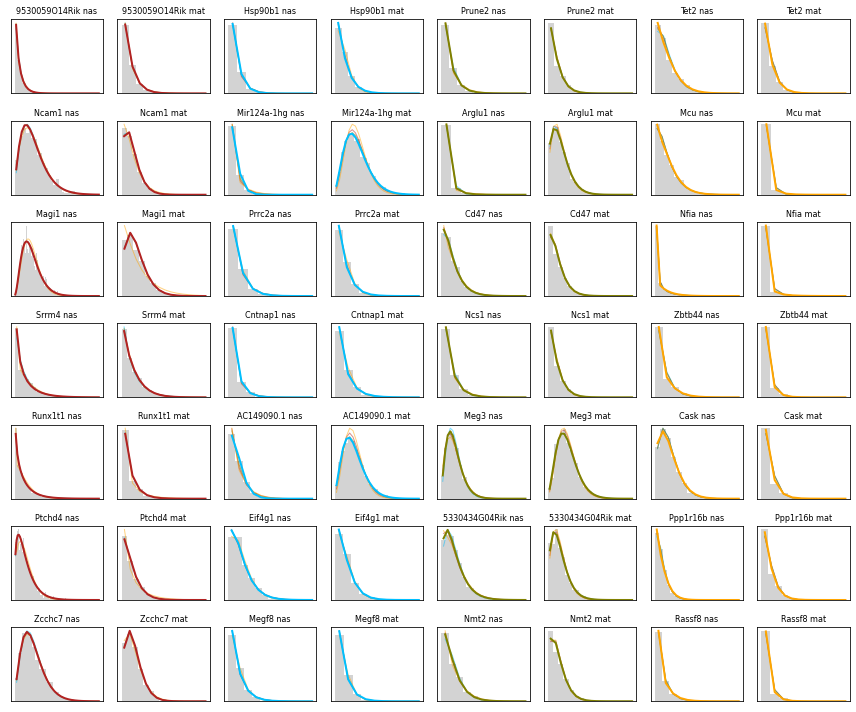

In [107]:
fig1,ax1=plt.subplots(n_rows,n_cols,figsize=(12,10))
for model_ind in range(4):
    for gene_ind in range(n_genes_per):
        gi = genes_to_plot[model_ind,gene_ind]
        
        data = sd.layers[:,gi,:]
        U = data[0]
        S = data[1]


        bins = np.arange(U.max()+2)-0.5
        ax1[gene_ind,model_ind*2].hist(U,bins,color='lightgray',density=True)

        bins = np.arange(S.max()+2)-0.5
        ax1[gene_ind,model_ind*2+1].hist(S,bins,color='lightgray',density=True)

        ax1[gene_ind,model_ind*2].set_xticks([])
        ax1[gene_ind,model_ind*2].set_yticks([])
        ax1[gene_ind,model_ind*2+1].set_xticks([])
        ax1[gene_ind,model_ind*2+1].set_yticks([])
        
        ax1[gene_ind,model_ind*2].set_title(gn[gi]+' nas',fontsize=8)
        ax1[gene_ind,model_ind*2+1].set_title(gn[gi]+' mat',fontsize=8)

        for model_ind_plot in range(4):
            lm = [U.max()+5,1]
            lw_ = 2 if model_ind==model_ind_plot else 1
            alpha=1 if model_ind==model_ind_plot else 0.5
            zord=100 if model_ind==model_ind_plot else 1
            
            p = mean_pars[model_ind_plot,gi,:]
            Pss = fitmodels[model_ind_plot].eval_model_pss(p,lm)
            ax1[gene_ind,model_ind*2].plot(Pss,color=modelcols[model_ind_plot],linewidth=lw_,
                          alpha=alpha,label=model_names_axes3[model_ind],
                         zorder=zord)

            lm = [1,S.max()+5]
            Pss = fitmodels[model_ind_plot].eval_model_pss(p,lm)
            ax1[gene_ind,model_ind*2+1].plot(Pss,color=modelcols[model_ind_plot],linewidth=lw_,
                          alpha=alpha,label=model_names_axes3[model_ind],
                         zorder=zord)
fig1.tight_layout()
plt.savefig('./fig/supp_fig_hists.png',dpi=450)
